In [1]:
# Import required packages for handling data, plotting and building models
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as kr
import matplotlib.pyplot as plt
%matplotlib inline
kr.backend.clear_session()
import secrets
import os
print(os.getcwd())
import pandas as pd
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

/storage1/fs1/pathaka/Active/lab/Jairaj/home/jairaj.mathur/PCAM-kaggle/100522-densenet121


In [3]:
#READ CSV INTO PANDAS DATAFRAME
root_dir = "/storage1/fs1/pathaka/Active/lab/Jairaj/home/jairaj.mathur/PCAM-kaggle/"
image_dir = root_dir+"train/"
train_raw = pd.read_csv(root_dir+"/train_labels.csv")#.sample(512)

train_raw.keys

<bound method NDFrame.keys of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

0 ee4f1c7f35a615b0d65f23cda7dd8ba22b436998 1
1 c4eaf141465b5f07910aa487e6917232c7c5948e 1
2 470eff39dbdecc6ad070f0ee635786537ac90d06 0
3 f9ebeb25755063fdc7562f7c27ff0d4b6a516767 1
4 4a86ed4604dbe4d56aa10bda3a0e0f48d71dce92 1
5 2cfcf96b8dd1c683a263610dc15ac88a8828e0e5 1
6 e2736141e19477d324b7945d8e495835fd6ee854 0
7 d2449e250b5d9dd9ba031fe3a8ce1a866bfd4fa1 1
8 f14ed20ba3ec2e112baa8c20dd4941f6dda11394 1
9 9ad02638754b16ff0636db64fb563515b37de99f 0
10 c2044d60e896cc6be8d74aa82467ecca9e6fd313 1
11 0292183429df669c5f5f8381c1e212ff32c54c09 1
12 ff88b39693a45beed791243a5c2b077cdb7f2e1f 1
13 77bb477479648dae5195b19731976eccf96f967d 0
14 835e0741d9177ad6323624668b1b5395d7a57361 0
15 237e61f152457d60eb39b441b9f1e8c219db8bfa 0


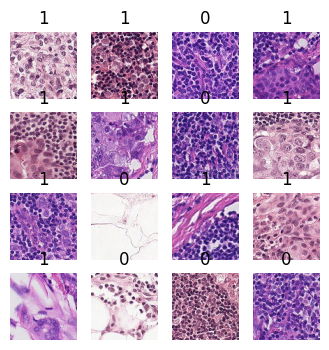

In [4]:
# Inspect Images
data_subset = train_raw.sample(16).reset_index()
plt.figure(figsize = (4,4))
for i, row in data_subset.iterrows():
    print(i, row.id, row.label)
    plt.subplot(4,4,i+1)
    img = mpimg.imread(image_dir+row.id+".tif")
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
    

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

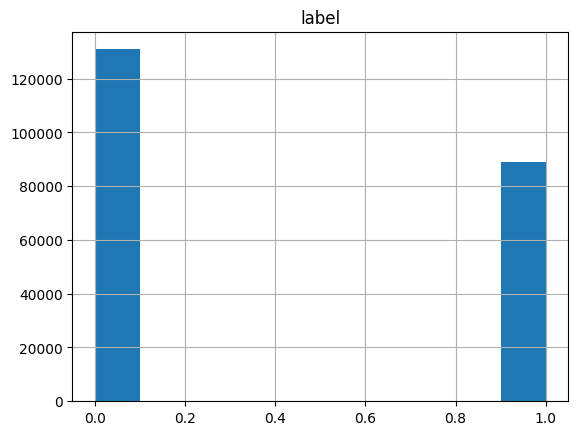

In [6]:
train_raw.id+= '.tif'
# Check label distribution for dataset
train_raw.hist(column='label')

In [7]:
#skippedFiles= 0
#for filename in os.listdir(image_dir):
#    filepath= os.path.join(image_dir,filename)
#    try:
#        fileobj= open(filepath,'rb')#read, Binary
#        #print(fileobj.peek(10))
#        isValid= tf.compat.as_bytes('tif') in fileobj.peek(10)
#    finally:
#        fileobj.close
#    if not isValid:
#        skippedFiles+= 1
#        print(filepath)
#        os.remove(filepath)
#print(skippedFiles)

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

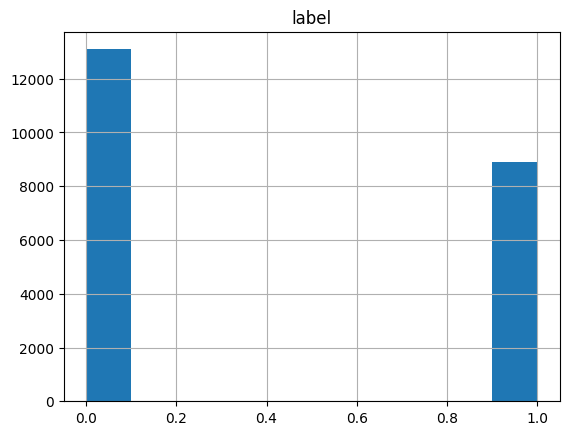

In [9]:
# Split the dataset into training and validation sets
#Create stratified splits to maintain label distribution across train and valid
df_train, df_valid = train_test_split(train_raw, test_size=0.1, 
                                     random_state= secrets.randbelow(1000), 
                                     shuffle= True, stratify=train_raw['label']
                                    )

df_valid.hist(column='label')

In [14]:
# Create data generators for the training and validation sets with image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zoom = 0.0 # Data Augmentation
shear = 0.0 # Data Augmentation

pp_input = kr.applications.densenet.preprocess_input
datagen_train = ImageDataGenerator(
#     rotation_range= 90,
# #     width_shift_range= 0.1,
# #     height_shift_range= 0.1,
#     zoom_range= ((1-zoom), 1),
#     shear_range= shear,
     horizontal_flip = True,
#      brightness_range= (0.75, 1.25),
     vertical_flip = True,
     preprocessing_function= pp_input
)

val_datagen = ImageDataGenerator(preprocessing_function= pp_input)

# Create loaders for the training and validation sets
# Load data efficiently one batch at a time
seed = secrets.randbelow(1000)
train_loader = datagen_train.flow_from_dataframe(
                dataframe= df_train, directory= image_dir, 
                x_col='id', y_col='label',
                batch_size= 32, shuffle=True,
                class_mode= 'raw', seed= seed,
                target_size= (96,96))

val_loader = val_datagen.flow_from_dataframe(
                dataframe= df_valid, directory= image_dir, 
                x_col='id', y_col='label',
                batch_size= 512, shuffle=True,
                class_mode= 'raw', seed= seed,
                target_size= (96,96))

Found 22003 validated image filenames.


In [15]:
# Define the model architecture
def net_model(image_size):
    IMAGE_SHAPE = (image_size +(3,))
    base_model = kr.applications.densenet.DenseNet121(
        include_top=False, weights= 'imagenet', input_shape=IMAGE_SHAPE)
    
#     base_model.trainable= False
    #CREATE INPUT LAYER
    inputs = kr.Input(shape=IMAGE_SHAPE)
#     inputs= pp_input(inputs)
    x = base_model(inputs)

    out1 = kr.layers.Flatten()(x)
    out2 = kr.layers.GlobalAveragePooling2D()(x)
    out3 = kr.layers.GlobalMaxPool2D()(x)
    
    out = kr.layers.Concatenate(axis=-1)([out1, out2, out3])
    out = kr.layers.Dropout(0.2)(out)
    
    output = kr.layers.Dense(1, activation= 'sigmoid')(out)
    model = kr.Model(inputs, output)
    
    return model

In [18]:
# Set model hyperparameters and compile
LR = 0.0001
dec_fac = 0.75
Mod = net_model((96,96))

Mod.compile(optimizer=kr.optimizers.Adam(learning_rate= LR), 
             loss= kr.losses.BinaryCrossentropy(),
             metrics=['accuracy', 'AUC'])

# Set checkpoints for model
rand = secrets.randbelow(1000)
# filepath = "best-LR-"+str(LR)+"-.epoch{epoch:02d}"+"-zm-"+str(zoom)+"-shr-"+str(shear)+str(rand)+".hdf5"
filepath = "best-LR-"+str(LR)+"-zm-"+str(zoom)+"-shr-"+str(shear)+str(rand)+".hdf5"
checkpoint_loss = kr.callbacks.ModelCheckpoint(filepath="loss-"+filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True)

checkpoint_acc = kr.callbacks.ModelCheckpoint(filepath="acc-"+filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True)

checkpoint_auc = kr.callbacks.ModelCheckpoint(filepath="auc-"+filepath, 
                             monitor='val_auc',
                             verbose=1, 
                             save_best_only=True, mode= 'max')

redLR = kr.callbacks.ReduceLROnPlateau(monitor="val_loss", factor= dec_fac,
                                      patience= 2, verbose=1, min_delta= 0.02, min_lr= LR*dec_fac**4)

callbacks = [checkpoint_loss, checkpoint_acc, checkpoint_auc, redLR]

In [19]:
history = Mod.fit(train_loader,validation_data=val_loader, epochs=15, callbacks=callbacks, workers= 16)

Epoch 1/15
6188/6189 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9210 - auc: 0.9710
Epoch 1: val_loss improved from inf to 0.15671, saving model to loss-best-LR-0.0001-zm-0.0-shr-0.0976.hdf5

Epoch 1: val_accuracy improved from -inf to 0.94405, saving model to acc-best-LR-0.0001-zm-0.0-shr-0.0976.hdf5

Epoch 1: val_auc improved from -inf to 0.98362, saving model to auc-best-LR-0.0001-zm-0.0-shr-0.0976.hdf5
6189/6189 [==============================] - 381s 59ms/step - loss: 0.2093 - accuracy: 0.9211 - auc: 0.9710 - val_loss: 0.1567 - val_accuracy: 0.9441 - val_auc: 0.9836 - lr: 1.0000e-04
Epoch 2/15
6189/6189 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9496 - auc: 0.9863
Epoch 2: val_loss improved from 0.15671 to 0.12446, saving model to loss-best-LR-0.0001-zm-0.0-shr-0.0976.hdf5

Epoch 2: val_accuracy improved from 0.94405 to 0.95592, saving model to acc-best-LR-0.0001-zm-0.0-shr-0.0976.hdf5

Epoch 2: val_auc improved from 0.98362

(0.0, 0.3)

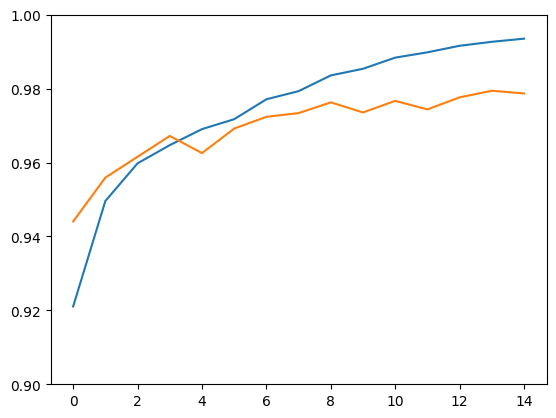

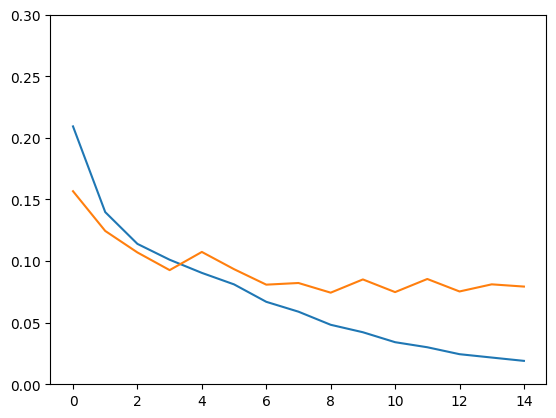

In [20]:
#Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure()
plt.plot(acc)
#plt.ylim([0,1])
#plt.figure()
plt.plot(val_acc)
plt.ylim([0.9,1])

plt.figure()
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.ylim([0,0.3])

In [24]:
# Create list of images and filenames for creating test set 
# and creating Kaggle submission
def load_images_filenames(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        filenames.append(os.path.splitext(filename)[0])
    return images, filenames

X, filenames = load_images_filenames(root_dir+"/test")

X_np = np.array(X)

ds_test = tf.data.Dataset.from_tensor_slices(X_np)

filenames_np = np.array(filenames)

In [28]:
# Function to create various augmentations for testing
# TTA helps improve predictive power
# create a function to generate TTA functions on the fly to be used with 
# test set creation
def tta(image, flips=None, rotations=0): 
    image = tf.cast(image, tf.float32)

    if flips:
        if "LR" in flips:
            image = tf.image.flip_left_right(image)
        if "UD" in flips:
            image = tf.image.flip_up_down(image)

    image = tf.image.rot90(image, k=rotations)

    return image

AUTOTUNE = tf.data.AUTOTUNE
# Create test dataset with augmentation
def prepare_dataset(ds, tta_options, batch_size=512):
    return (ds.map(lambda x: tta(x, **tta_options))
             .map(lambda x: pp_input(x))
             .batch(batch_size)
             .prefetch(AUTOTUNE))
# A combination of flips and rotations
tta_options_list = [
    {"flips": None, "rotations": 0},
    {"flips": ["LR"], "rotations": 0},
    {"flips": ["UD"], "rotations": 0},
    {"flips": ["LR", "UD"], "rotations": 0},
    {"flips": None, "rotations": 1},
    {"flips": None, "rotations": 3},
    {"flips": ["UD"], "rotations": 1},
    {"flips": ["UD"], "rotations": 3},
]

test_aug_datasets = [prepare_dataset(ds_test, options) for options in tta_options_list]

def out_tta_preds(model, test_datasets):
    preds = sum(model.predict(ds) for ds in test_datasets) / len(test_datasets)
    return preds

preds = out_tta_preds(Mod, test_aug_datasets)


In [33]:
# Load best model and create submission output for Kaggle
Mod = kr.models.load_model("loss-"+filepath)
preds = out_tta_preds(Mod)
df_submission = pd.DataFrame({'id':filenames_np, 'label':np.squeeze(preds)})
df_submission.to_csv("loss-"+filepath+"submission.csv", index=False)

113/113 [==============================] - 9s 78ms/step


In [34]:
print(rand)

#AUC value screenshot for Kaggle submission

976


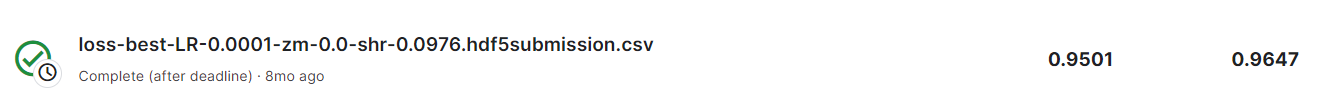